In [44]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

os.getcwd()

os.chdir('C:\\Users\\admin\\Desktop\\Dart\\Project\\ETF modeling')

from pandas import Timestamp

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import MinMaxScaler, RobustScaler, power_transform, PowerTransformer
from sklearn.base import is_classifier
from sklearn.utils import indexable, Parallel, delayed

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor


from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, skew, norm, boxcox_normplot, boxcox

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll import scope
from hyperopt.pyll_utils import hp_quniform

import seaborn as sns
from pylab import plot, show

import inspect
import hyperopt.pyll

from hyperopt import pyll_utils
import xgboost as xgb
from xgboost import *

import scipy.sparse as sp
import numbers
from collections.abc import Iterable

from math import log


####################################################################
####################################################################
####################################################################

scope.define(GradientBoostingRegressor)
scope.define(XGBRegressor)
scope.define(Ridge)
scope.define(Lasso)
scope.define(ElasticNet)
scope.define(MLPRegressor)

####################################################################
####################################################################
####################################################################

def slidingwindow(dataname, Yname, len_train, len_test):
    
    if Yname == None:
        data_x = dataname
    else:
        data_x = dataname.drop(Yname, axis = 1)  
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for i in range(0, (len(dataname) - len_train - len_test), len_test):
        x_train.append(data_x[i : (i + len_train)])
        x_test.append(data_x[(len_train + i) : (len_train + len_test + i)])
        
    
    if not Yname == None:
        data_y = dataname[Yname]
        for i in range(0, (len(dataname) - len_train - len_test), len_test):
            y_train.append(data_y[i : (i + len_train)])
            y_test.append(data_y[(len_train + i) : (len_train + len_test + i)])
            
    return x_train, y_train, x_test, y_test

def singlenorm(data):
    normed = ((data - data.min(axis=0))/(data.max(axis=0) - data.min(axis=0)))
    return normed

def multinorm(data):
    data_norm = data[:]
    for j in data_norm.columns:
        data_norm[j] = ((data_norm[j] - data_norm[j].min(axis=0))/(data_norm[j].max(axis=0) - data_norm[j].min(axis=0)))
    return data_norm

def uniint(label, *args, **kwargs):
    args += (1,)
    return scope.int(hp_quniform(label, *args, **kwargs))

def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

def makedataset(dataname, Yname, len_train, len_test):
    x_train, y_train, x_test, y_test = slidingwindow(dataname, Yname, len_train, len_test)
    
    y_train_norm = []
    y_test_norm = []
    x_train_norm = []
    x_test_norm = []

    for i in range(0, len(x_train)):
        y_train_norm.append(singlenorm(y_train[i]))
        y_test_norm.append(singlenorm(y_test[i]))
        x_train_norm.append(multinorm(x_train[i]))
        x_test_norm.append(multinorm(x_test[i]))

    #for i in range(0, len(x_train)):
     #   x_train_norm[i] = logs(x_train_norm[i], x_train_norm[i].columns)
     #   x_test_norm[i] = logs(x_test_norm[i], x_test_norm[i].columns)

    return x_train_norm, y_train_norm, x_test_norm, y_test_norm


def paramtuning(x_train_norm, y_train_norm, search_space_regression, start, end, seq):
    result = []
    for j in range(start, end, seq):
        x_train = x_train_norm[j].fillna(0)
        y_train = y_train_norm[j].fillna(0)
        x_test = x_test_norm[j].fillna(0)
        y_test = y_test_norm[j].fillna(0)
        def objective_function_regression(estimator):
            estimator.fit(x_train, y_train)
            yhat1 = estimator.predict(x_train)
            error1 = mean_absolute_error(y_train, yhat1)
            yhat2 = estimator.predict(x_test)
            error2 = mean_absolute_error(y_test, yhat2)
            em1 = np.mean(error1)
            em2 = np.mean(error2)

            return (em1 + em2)

        best = fmin(
            fn = objective_function_regression,
            space = search_space_regression,
            algo = tpe.suggest,
            max_evals = 100,
            verbose = 2
            )
        print(best)
        result.append(best)

    return result


def paramtuning2(x_train_norm, y_train_norm, x_test_norm, y_test_norm, search_space_regression, start, end, seq):
    result = []
    
        
    def objective_function_regression(estimator):
        error = []
        for j in range(start, end, seq):
            x_train = x_train_norm[j]
            y_train = y_train_norm[j]
            x_test = x_test_norm[j]
            y_test = y_test_norm[j]

            estimator.fit(x_train, y_train)
            yhat = estimator.predict(x_test)
            error.append(mean_absolute_error(y_test, yhat))

        return np.mean(error)

    best = fmin(
        fn = objective_function_regression,
        space = search_space_regression,
        algo = tpe.suggest,
        max_evals = 100,
        verbose = 2
        )
    print(best)
    result.append(best)

    return result

def paramtuning3(x_train_norm, y_train_norm, x_test_norm, y_test_norm, search_space_regression, start, end, seq):
    result = []
    for j in range(start, end, seq):
        def objective_function_regression(estimator):
            error = cross_val_score(estimator, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error))
            return np.mean(error)

        best = fmin(
            fn = objective_function_regression,
            space = search_space_regression,
            algo = tpe.suggest,
            max_evals = 100,
            verbose = 2
            )
        print(best)
        result.append(best)

    return result


def termtuning(x_train_norm, y_train_norm, search_space_regression, start, end, seq):
    result = []
    for j in range(start, end, seq):
        x_train = x_train_norm[j].fillna(method='ffill')
        y_train = y_train_norm[j].fillna(method='ffill')
        
        def objective_function_regression(estimator):
            error = cross_val_score(estimator, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error))
            return np.mean(error)

        best = fmin(
            fn = objective_function_regression,
            space = search_space_regression,
            algo = tpe.suggest,
            max_evals = 10,
            verbose = 2
            )
        print(best)
        result.append(best)

    return result

def plotresult(yhat, result, i):
    plt.scatter(yhat, y_test_norm[i])
    plt.ylabel('Expected')
    plt.xlabel('Predicted')
    plt.plot([0, 1], [0, 1])
    plt.show()

    plt.plot(((yhat * (y_test[i].max(axis=0) - y_test[i].min(axis=0))) + y_test[i].min(axis=0)), label = 'Predict')
    plt.plot(y_test[i], label = 'Expected')
    plt.legend(loc=3)
    plt.show()
    
    Regressor = GradientBoostingRegressor(loss = losslist[gbrresult[i]['loss']],
                                              learning_rate = gbrresult[i]['learning_rate'],
                                             max_depth = int(gbrresult[i]['max_depth']),
                                             max_features = int(gbrresult[i]['max_features']),
                                             min_samples_leaf = int(gbrresult[i]['min_samples_leaf']),
                                             n_estimators = int(gbrresult[i]['n_estimators']))

    Regressor.fit(x_train_norm[i], y_train_norm[i])
    gbr_yhat = Regressor.predict(x_test_norm[i])
    feature_importance = Regressor.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance[0:20])
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x_train_norm[i].columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    ;

    
def returncal(dataname, ret_len):
    data_y = dataname
    data_y1 = data_y[ret_len:]
    data_y2 = data_y[:-ret_len]
    data_y1.index = range(0, len(data_y1))
    data_y2.index = range(0, len(data_y2))
    y_return = ((data_y2-data_y1)/data_y1)*100
    y_return.index = data_y.index[ret_len:]
    
    
    y_return.columns = y_return.columns + '_' + str(ret_len)
    
    return y_return

def makereturn(dataname, Yname, ret_len):
    data_y = dataname[Yname]
    data_x = dataname.drop(Yname, axis = 1) 
    
    #y 변환
    data_y1 = data_y[ret_len:]
    data_y2 = data_y[:-ret_len]
    data_y1.index = range(0, len(data_y1))
    data_y2.index = range(0, len(data_y2))
    y_return = ((data_y2-data_y1)/data_y1)*100
    y_return.index = data_y.index[:-ret_len]
    
    #x 변환
    for i in [1, 5, 60, 150]:
        y_return = pd.merge(y_return, returncal(data_x, i), how = 'inner', left_index = True, right_index = True)
    
    return y_return


def makemean(dataname, Yname, length):
    data_y = dataname[Yname]
    data_x = dataname.drop(Yname, axis = 1)
    data_mean = data_x[:]
    for i in [5, 15, 60, 150]:
        data_m = data_x.rolling(window=i).mean().dropna()
        data_md = data_m/data_x
        data_m.columns = data_m.columns + '_' + str(i)
        data_md.columns = data_md.columns + '_div' + str(i)
        data_mean = pd.merge(data_mean, data_m, how = 'inner', left_index = True, right_index = True)
        data_mean = pd.merge(data_mean, data_md, how = 'inner', left_index = True, right_index = True)
    
    data_y_cut = data_y[length:]
    data_y_cut.index = data_y.index[:-length]
    
    data_fin = pd.merge(data_mean, data_y_cut, how = 'inner', left_index = True, right_index = True)
    
    return data_fin

def datalabeling(data, labelname, start, end, seq):
    dataname = data[:]
    label = labelname + '_labeled'
    dataname[label] = ''
    for i in range(start, (end+1), seq):
        if i==start:
            dataname[label][dataname[labelname] <= i] = 'under ' + str(i)
            dataname[label][dataname.index.isin(dataname[label][dataname[labelname] > i][dataname[labelname] <= (i+seq)].index)]= str(i)
        elif i==end:
            dataname[label][dataname[labelname] > i] = 'over ' + str(i)
        else:
            dataname[label][dataname.index.isin(dataname[label][dataname[labelname] > i][dataname[labelname] <= (i+seq)].index)]= str(i)
    
    return dataname[label]

def skewfix(data):
    datareturn = data[:]
    skewed = []
    for i in datareturn.columns:
        if (boxcox(datareturn[i], alpha = 0.05)[2][0] > 1) or (boxcox(datareturn[i], alpha = 0.05)[2][1] < 1):
            skewed.append(i)
    
    for i in skewed:
        datareturn[i] = boxcox1p(datareturn[i], boxcox(datareturn[i])[1])

    return datareturn



####################################################################
####################################################################
####################################################################

feature = pd.DataFrame(pd.read_csv('EM data.csv'))
sp500 = pd.DataFrame(pd.read_csv('SP500.csv'))
EAFE = pd.DataFrame(pd.read_csv('EAFE.csv'))
EM = pd.DataFrame(pd.read_csv('EM.csv'))
gold = pd.DataFrame(pd.read_csv('gold.csv'))
wti = pd.DataFrame(pd.read_csv('wti.csv'))


dataset = pd.merge(feature, sp500, how = 'inner', left_on = 'Date', right_on = 'Date')
dataset = pd.merge(dataset, EM, how = 'inner', left_on = 'Date', right_on = 'Date')
dataset = pd.merge(dataset, EAFE, how = 'inner', left_on = 'Date', right_on = 'Date')
dataset = pd.merge(dataset, gold, how = 'inner', left_on = 'Date', right_on = 'Date')
dataset = pd.merge(dataset, wti, how = 'inner', left_on = 'Date', right_on = 'Date')


dataset = dataset.set_index('Date')
dataset = dataset.fillna(method='ffill')
dataset = dataset.fillna(method='bfill')

labeldata = pd.DataFrame(pd.read_csv('labeldata.csv')).set_index('Date').fillna(method='ffill').fillna(method='bfill')

t3month = datalabeling(labeldata, 't3month', 1, 5, 1)
t1yr = datalabeling(labeldata, 'T1yr', 1, 5, 1)
t3yr = datalabeling(labeldata, 'T3yr', 1, 5, 1)
t10yr = datalabeling(labeldata, 'T10yr', 1, 5, 1)
phil = datalabeling(labeldata, 'phil', -30, 30, 10)
unem = datalabeling(labeldata, 'unnemploy', 3, 8, 1)
infla = datalabeling(labeldata, 'inflation rate', -5, 5, 1)

datalabel = pd.concat([t3month, t1yr, t3yr, t10yr, phil, unem, infla], axis = 1)


datalabel = datalabel[datalabel.index.isin(datareturn.index)]


####################################################################
####################################################################
####################################################################


ValueError: ('Cannot override existing symbol', 'GradientBoostingRegressor')

In [17]:
gbrresult

,Unnamed: 0,estimator,learning_rate,loss,max_depth,max_features,min_samples_leaf,n_estimators
0,0,0,0.114857,0,3.0,187.0,9.0,409.0
1,1,0,0.157820,1,5.0,208.0,22.0,851.0
2,2,0,0.090024,0,5.0,205.0,22.0,950.0
3,3,0,0.155014,0,9.0,167.0,59.0,701.0
4,4,0,0.156223,1,4.0,201.0,54.0,314.0
...,...,...,...,...,...,...,...,...
326,326,0,0.102934,0,5.0,210.0,27.0,502.0
327,327,0,0.114118,0,9.0,186.0,6.0,272.0
328,328,0,0.077669,0,7.0,184.0,5.0,755.0
329,329,0,0.165522,0,6.0,191.0,8.0,319.0


In [53]:
seq = 1
#Ridge Tuning
alpha = hp.uniform('alpha', 0.1, 0.9)


ridge_est0 = (0.1, scope.Ridge(alpha = alpha,
                                    random_state = 42))
ridge_space = hp.pchoice('estimator', [ridge_est0])

ridgeresult = paramtuning(x_train_norm, y_train_norm, ridge_space, 0, len(x_train_norm), seq)


#Lasso Tuning
alpha = hp.uniform('alpha', 0.1, 0.9)


lasso_est0 = (0.1, scope.Lasso(alpha = alpha,
                                    random_state = 42))
lasso_space = hp.pchoice('estimator', [lasso_est0])

lassoresult = paramtuning(x_train_norm, y_train_norm, lasso_space, 0, len(x_train_norm), seq)


#Elasticnet Tuning
alpha = hp.uniform('alpha', 0.1, 0.9)
l1_ratio = hp.uniform('l1_ratio', 0.1, 0.9)

ela_est0 = (0.1, scope.ElasticNet(alpha = alpha,
                             l1_ratio = l1_ratio,
                             fit_intercept = True,
                                    random_state = 42))
ela_space = hp.pchoice('estimator', [ela_est0])

elaresult = paramtuning(x_train_norm, y_train_norm, ela_space, 0, len(x_train_norm), seq)


100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.55it/s, best loss: 0.4336256612017879]
{'alpha': 0.5464583079037619, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.37it/s, best loss: 0.5865820322270013]
{'alpha': 0.8996434940131871, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 154.50it/s, best loss: 0.6608694407520649]
{'alpha': 0.8992355504772024, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.63it/s, best loss: 0.5939697735220323]
{'alpha': 0.10008608781808807, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 138.30it/s, best loss: 0.46622394188162397]
{'alpha': 0.10026354541027024, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 145.32it/s, best loss: 0.39364176458563377]
{'alpha': 0.8997062342770951, 'estimator': 0}
10

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 160.94it/s, best loss: 0.5300055566357382]
{'alpha': 0.8998664475519832, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 173.46it/s, best loss: 0.42968056493987417]
{'alpha': 0.8985716634906858, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.47it/s, best loss: 0.2889337584598202]
{'alpha': 0.5561515191130412, 'estimator': 0}
100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.76it/s, best loss: 0.527805484211112]
{'alpha': 0.8999156538335333, 'estimator': 0}
100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 171.40it/s, best loss: 0.27383082548658]
{'alpha': 0.8992113590861399, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.41it/s, best loss: 0.6798420698405387]
{'alpha': 0.10025623081369547, 'estimator': 0}
100

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 183.96it/s, best loss: 0.35920161105990606]
{'alpha': 0.10015935996687783, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 175.91it/s, best loss: 0.42389744581322875]
{'alpha': 0.8999706270005786, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.77it/s, best loss: 0.3519739351174851]
{'alpha': 0.3267360597719467, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.07it/s, best loss: 0.3717191408168617]
{'alpha': 0.10085636332633406, 'estimator': 0}
100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.99it/s, best loss: 0.584588967586273]
{'alpha': 0.8995713035758612, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 176.84it/s, best loss: 0.2813745343985576]
{'alpha': 0.899829978896688, 'estimator': 0}
100

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 175.00it/s, best loss: 0.38297945876635753]
{'alpha': 0.10027582509084967, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 151.24it/s, best loss: 0.4155882360578315]
{'alpha': 0.10122102436937051, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 157.32it/s, best loss: 0.5558630172031991]
{'alpha': 0.8998281604793569, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 182.30it/s, best loss: 0.39598511205228604]
{'alpha': 0.8998040899007101, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 168.23it/s, best loss: 0.26608129734664665]
{'alpha': 0.8999833761612727, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 162.24it/s, best loss: 0.7549873253438361]
{'alpha': 0.8996649187236846, 'estimator': 0}
10

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 139.65it/s, best loss: 0.29607491461228275]
{'alpha': 0.28230051842738196, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.77it/s, best loss: 0.3325152153391043]
{'alpha': 0.10027642304497819, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 167.39it/s, best loss: 0.14185482018599344]
{'alpha': 0.10015435986484932, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.68it/s, best loss: 0.3664355970172388]
{'alpha': 0.698926725014473, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 125.33it/s, best loss: 0.3187645660953492]
{'alpha': 0.8997390242712859, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 167.95it/s, best loss: 0.2832877900365103]
{'alpha': 0.13528430060021254, 'estimator': 0}
1

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 166.01it/s, best loss: 0.5476716994090188]
{'alpha': 0.10095904085014847, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 152.85it/s, best loss: 0.3649822403159156]
{'alpha': 0.8998004124392974, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 167.95it/s, best loss: 0.3753855921435227]
{'alpha': 0.10010667881059342, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 155.93it/s, best loss: 0.24166703986720578]
{'alpha': 0.10066675313823108, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 166.83it/s, best loss: 0.1669772672430744]
{'alpha': 0.37382769631066903, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 157.15it/s, best loss: 0.5369397218646069]
{'alpha': 0.8996546416430253, 'estimator': 0}


100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 169.09it/s, best loss: 0.4637077684427292]
{'alpha': 0.10006799356442209, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 167.11it/s, best loss: 0.47046724139272456]
{'alpha': 0.8996817132762859, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 167.67it/s, best loss: 0.21309736114837308]
{'alpha': 0.8995472723722724, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 162.77it/s, best loss: 0.43802748870854924]
{'alpha': 0.8998466533185956, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 168.23it/s, best loss: 0.36417197694586023]
{'alpha': 0.10007958479575761, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 175.29it/s, best loss: 0.45051035378801707]
{'alpha': 0.8997373335338891, 'estimator': 0}
10

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 181.64it/s, best loss: 0.49270010738168546]
{'alpha': 0.7519858398254529, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.65it/s, best loss: 0.4727223339321832]
{'alpha': 0.572682403072489, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 177.15it/s, best loss: 0.5758578334462563]
{'alpha': 0.8213947718952505, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 177.78it/s, best loss: 0.5052074281738677]
{'alpha': 0.7524560570283904, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.09it/s, best loss: 0.5702472286827005]
{'alpha': 0.283020501270582, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.99it/s, best loss: 0.4620936054421765]
{'alpha': 0.7432681396812516, 'estimator': 0}
100%|█

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 183.64it/s, best loss: 0.5911601471395198]
{'alpha': 0.8237146393121382, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 160.94it/s, best loss: 0.5379545098797495]
{'alpha': 0.49107097934469124, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 186.37it/s, best loss: 0.48829440720006734]
{'alpha': 0.6455628183338914, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 182.97it/s, best loss: 0.5794431685097765]
{'alpha': 0.7127570187163649, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.62it/s, best loss: 0.4139973480979774]
{'alpha': 0.740520733904319, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 176.22it/s, best loss: 0.4141630810484878]
{'alpha': 0.8829187741686501, 'estimator': 0}
100%

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 175.90it/s, best loss: 0.5807708311823365]
{'alpha': 0.31160706758134393, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 203.78it/s, best loss: 0.5469866005610009]
{'alpha': 0.45551454544899206, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 184.31it/s, best loss: 0.6025596905544177]
{'alpha': 0.8957346882026443, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 183.29it/s, best loss: 0.6319672968869449]
{'alpha': 0.6505168109264574, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 189.53it/s, best loss: 0.5989598376646106]
{'alpha': 0.2650773386414552, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 193.57it/s, best loss: 0.5405907997972003]
{'alpha': 0.7900987129916851, 'estimator': 0}
10

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 187.77it/s, best loss: 0.5510660036387849]
{'alpha': 0.3206591865627318, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.61it/s, best loss: 0.6297054610021506]
{'alpha': 0.21768888109349485, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 182.63it/s, best loss: 0.49487018135971617]
{'alpha': 0.7524976482601604, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 195.83it/s, best loss: 0.49677795924180523]
{'alpha': 0.3140257732677507, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 177.15it/s, best loss: 0.5575671938611046]
{'alpha': 0.6403071395038292, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 192.82it/s, best loss: 0.5282577405226034]
{'alpha': 0.2029844243869511, 'estimator': 0}
100

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.47it/s, best loss: 0.5565361879792496]
{'alpha': 0.28350646475829366, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 185.33it/s, best loss: 0.5073548271709116]
{'alpha': 0.21052045126675517, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.35it/s, best loss: 0.5595839574054665]
{'alpha': 0.1560003980569662, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 189.54it/s, best loss: 0.5385554887768162]
{'alpha': 0.6371459538675884, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 195.45it/s, best loss: 0.5398891819648467]
{'alpha': 0.6805015942752157, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 190.26it/s, best loss: 0.5110239462861513]
{'alpha': 0.5917556159066452, 'estimator': 0}
10

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 179.05it/s, best loss: 0.44935060948873157]
{'alpha': 0.6839231653753483, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.83it/s, best loss: 0.4435242428714732]
{'alpha': 0.772003725636126, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 196.99it/s, best loss: 0.43213032563586906]
{'alpha': 0.15212430413817302, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 188.47it/s, best loss: 0.5774021937546797]
{'alpha': 0.5663588144983712, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 174.08it/s, best loss: 0.4998640584864674]
{'alpha': 0.7422833406600156, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 191.72it/s, best loss: 0.5265589573710912]
{'alpha': 0.2904799317862248, 'estimator': 0}
100%

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 186.03it/s, best loss: 0.5519970631424368]
{'alpha': 0.34220167079272407, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 154.50it/s, best loss: 0.42436217431928325]
{'alpha': 0.2837585884705496, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 169.37it/s, best loss: 0.5808014418170454]
{'alpha': 0.2173942661991756, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 192.81it/s, best loss: 0.46240015840015625]
{'alpha': 0.466613616093018, 'estimator': 0}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 180.34it/s, best loss: 0.49484263376346826]
{'alpha': 0.6247460082381937, 'estimator': 0}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.10it/s, best loss: 0.5274546636215299]
{'alpha': 0.7434105871404658, 'estimator': 0}
100%

100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.82it/s, best loss: 0.406080590898951]
{'alpha': 0.11724087624648441, 'estimator': 0, 'l1_ratio': 0.10014468916023511}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.65it/s, best loss: 0.5400914112287845]
{'alpha': 0.10115455029641587, 'estimator': 0, 'l1_ratio': 0.18279663278567684}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 142.43it/s, best loss: 0.36736250643825363]
{'alpha': 0.10046293438330528, 'estimator': 0, 'l1_ratio': 0.10766288349525863}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 132.80it/s, best loss: 0.4530080859503379]
{'alpha': 0.10378289878112076, 'estimator': 0, 'l1_ratio': 0.2319218675474021}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 150.09it/s, best loss: 0.39580488783453793]
{'alpha': 0.10025065726398988, 'estimator': 0, 'l1_ratio': 0.24162824479627187}
1

100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.22it/s, best loss: 0.584099949401736]
{'alpha': 0.10433795819353343, 'estimator': 0, 'l1_ratio': 0.1062942133611806}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 144.48it/s, best loss: 0.5020519876964968]
{'alpha': 0.10593626127179577, 'estimator': 0, 'l1_ratio': 0.10024220459342786}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 151.01it/s, best loss: 0.48829440720006734]
{'alpha': 0.13701535778754287, 'estimator': 0, 'l1_ratio': 0.811207235589162}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 142.01it/s, best loss: 0.5698233236060328]
{'alpha': 0.10812891383050557, 'estimator': 0, 'l1_ratio': 0.10016558149698374}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 153.08it/s, best loss: 0.4139973480979774]
{'alpha': 0.567120585127692, 'estimator': 0, 'l1_ratio': 0.6784533042344056}
100%|█

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.43it/s, best loss: 0.4420780115335823]
{'alpha': 0.10000760239946276, 'estimator': 0, 'l1_ratio': 0.12300307228336713}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 154.26it/s, best loss: 0.45501493363120216]
{'alpha': 0.10251883898691215, 'estimator': 0, 'l1_ratio': 0.10120575246409308}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 155.21it/s, best loss: 0.5792833281150467]
{'alpha': 0.8059842127672304, 'estimator': 0, 'l1_ratio': 0.6501426783512829}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.99it/s, best loss: 0.5206813591375945]
{'alpha': 0.4041464938873277, 'estimator': 0, 'l1_ratio': 0.44490375116078107}
100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.65it/s, best loss: 0.488797625712882]
{'alpha': 0.10016658628905659, 'estimator': 0, 'l1_ratio': 0.10148338638635028}
100

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 143.24it/s, best loss: 0.49298675824095095]
{'alpha': 0.567419588400686, 'estimator': 0, 'l1_ratio': 0.1856091729836777}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 140.43it/s, best loss: 0.5020956846982636]
{'alpha': 0.8839124245006181, 'estimator': 0, 'l1_ratio': 0.6014261144824581}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 138.11it/s, best loss: 0.5847630817513312]
{'alpha': 0.7708280030784225, 'estimator': 0, 'l1_ratio': 0.4625152331240874}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.54it/s, best loss: 0.4812036044333896]
{'alpha': 0.8052111106904261, 'estimator': 0, 'l1_ratio': 0.5370447994662306}
100%|██████████████████████████████████████████████████| 100/100 [00:00<00:00, 132.10it/s, best loss: 0.52204022539552]
{'alpha': 0.5701157239483272, 'estimator': 0, 'l1_ratio': 0.8262788973300838}
100%|██████

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 132.45it/s, best loss: 0.45727655969761494]
{'alpha': 0.8130801253791499, 'estimator': 0, 'l1_ratio': 0.38947104199357985}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 145.10it/s, best loss: 0.45428499746519024]
{'alpha': 0.5968140820489927, 'estimator': 0, 'l1_ratio': 0.8878996677902398}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 147.45it/s, best loss: 0.5597342473880966]
{'alpha': 0.6519869401675419, 'estimator': 0, 'l1_ratio': 0.2492190565479879}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.21it/s, best loss: 0.4238689847709013]
{'alpha': 0.8952472161157211, 'estimator': 0, 'l1_ratio': 0.6507210016898124}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 138.30it/s, best loss: 0.49713006159141554]
{'alpha': 0.2844273609493895, 'estimator': 0, 'l1_ratio': 0.24003678683330715}
100%|███

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 145.32it/s, best loss: 0.45675507184737896]
{'alpha': 0.10051366002789798, 'estimator': 0, 'l1_ratio': 0.12224479867156512}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 148.54it/s, best loss: 0.49292382163379855]
{'alpha': 0.10250129174930682, 'estimator': 0, 'l1_ratio': 0.10906260937186406}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.32it/s, best loss: 0.5582886550146138]
{'alpha': 0.10344227078388929, 'estimator': 0, 'l1_ratio': 0.10959361454200278}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.33it/s, best loss: 0.5831979372687547]
{'alpha': 0.3841717713351457, 'estimator': 0, 'l1_ratio': 0.6824321222600873}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 146.38it/s, best loss: 0.4741103929940748]
{'alpha': 0.10086711844392465, 'estimator': 0, 'l1_ratio': 0.16426166420879612}
10

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 145.10it/s, best loss: 0.4972120753360862]
{'alpha': 0.4595987260871116, 'estimator': 0, 'l1_ratio': 0.48601734151317855}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 149.88it/s, best loss: 0.4810054188251599]
{'alpha': 0.14764250698512635, 'estimator': 0, 'l1_ratio': 0.3456968122649718}
100%|█████████████████████████████████████████████████| 100/100 [00:00<00:00, 148.32it/s, best loss: 0.519704444976081]
{'alpha': 0.13397917346694593, 'estimator': 0, 'l1_ratio': 0.10098222979985505}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 124.09it/s, best loss: 0.49452785001979005]
{'alpha': 0.5278931453501244, 'estimator': 0, 'l1_ratio': 0.5052386944743249}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 150.78it/s, best loss: 0.5055303728077064]
{'alpha': 0.49318147272413393, 'estimator': 0, 'l1_ratio': 0.4689355083465697}
100%|

100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 147.24it/s, best loss: 0.42436217431928325]
{'alpha': 0.7095557103950434, 'estimator': 0, 'l1_ratio': 0.41523715612039014}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 139.45it/s, best loss: 0.5808014418170454]
{'alpha': 0.5726058851277901, 'estimator': 0, 'l1_ratio': 0.6431621707049056}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 157.41it/s, best loss: 0.46240015840015625]
{'alpha': 0.41449477517300914, 'estimator': 0, 'l1_ratio': 0.8516264527013284}
100%|███████████████████████████████████████████████| 100/100 [00:00<00:00, 147.67it/s, best loss: 0.49484263376346826]
{'alpha': 0.6182788081643918, 'estimator': 0, 'l1_ratio': 0.4080438005082657}
100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 144.89it/s, best loss: 0.5262782280253897]
{'alpha': 0.11972957751876533, 'estimator': 0, 'l1_ratio': 0.1049697411129281}
100%|██

In [54]:
pd.DataFrame(elaresult).to_csv('eafeela.csv')
pd.DataFrame(ridgeresult).to_csv('eaferid.csv')
pd.DataFrame(lassoresult).to_csv('eafelas.csv')

In [302]:
idx = 'SP500'

datareturn = makemean(dataset, idx, 7)

x_train, y_train, x_test, y_test = slidingwindow(datareturn, idx, 157, 7)
print('1')
x_train_norm, y_train_norm, x_test_norm, y_test_norm = makedataset(datareturn, idx, 157, 7)
print('2')
#x_train_label, y_train_label, x_test_label, y_test_label = slidingwindow(datalabel, None, 150, 20)


gbrresult = pd.read_csv(idx + 'gbr.csv').to_dict(orient='record')
xgbresult = pd.read_csv(idx + 'xgb.csv').to_dict(orient='record')
mlpresult = pd.read_csv(idx + 'mlp.csv').to_dict(orient='record')
ridresult = pd.read_csv(idx + 'rid.csv').to_dict(orient='record')
lasresult = pd.read_csv(idx + 'las.csv').to_dict(orient='record')
elaresult = pd.read_csv(idx + 'ela.csv').to_dict(orient='record')


1
2


In [304]:
#이거 돌릴때 기존에 만든 데이터셋을 그대로 쓰면 안되고 validation에 사용한 길이만큼 train set에 포함시켜서 만들어줘야함
#예를들어 validation set 길이가 7이고 train set 길이가 150이면 157짜리를 새로 선언해줘야함
seq = 1
yhat_train = []
yhat_test = []

losslist = ('ls', 'lad')
activelist = ('relu', 'logistic', 'tanh')
solvlist = ('sgd', 'adam')

for i in range(0, len(gbrresult)-1):
    j = i*seq
    GBRegressor = GradientBoostingRegressor(loss = losslist[gbrresult[i]['loss']],
                                                  learning_rate = gbrresult[i]['learning_rate'],
                                                 max_depth = int(gbrresult[i]['max_depth']),
                                                 max_features = int(gbrresult[i]['max_features']),
                                                 min_samples_leaf = int(gbrresult[i]['min_samples_leaf']),
                                                 n_estimators = int(gbrresult[i]['n_estimators']),
                                               random_state = 42)

    GBRegressor.fit(x_train_norm[j], y_train_norm[j])

    gbr_yhat_train = GBRegressor.predict(x_train_norm[j])

    gbr_yhat_test = GBRegressor.predict(x_test_norm[j])




    XRegressor = XGBRegressor(learning_rate = xgbresult[i]['learning_rate'],
                                        colsample_bytree = xgbresult[i]['colsample_bytree'],
                                        colsample_bylevel = xgbresult[i]['colsample_bylevel'],
                                        colsample_bynode = xgbresult[i]['colsample_bynode'],
                                        gamma = xgbresult[i]['gamma'],
                                        max_depth = int(xgbresult[i]['max_depth']),
                                        min_child_weight = int(xgbresult[i]['min_child_weight']),
                                        n_estimators = int(xgbresult[i]['n_estimators']),
                                        reg_alpha = xgbresult[i]['reg_alpha'],
                                        reg_lambda = xgbresult[i]['reg_lambda'],
                                        random_state = 42)

    XRegressor.fit(x_train_norm[i], y_train_norm[j])

    xgb_yhat_train = XRegressor.predict(x_train_norm[j])

    xgb_yhat_test = XRegressor.predict(x_test_norm[j])


    MRegressor = MLPRegressor(hidden_layer_sizes=[int(mlpresult[i]['hidden_layer_sizes1']), 
                                                    int(mlpresult[i]['hidden_layer_sizes2'])],
                               activation=activelist[mlpresult[i]['activation']],
                                solver=solvlist[mlpresult[i]['solver']], 
                                alpha=mlpresult[i]['alpha'],
                                max_iter=int(mlpresult[i]['max_iter']), 
                                batch_size=int(mlpresult[i]['batch_size'])
                               )

    MRegressor.fit(x_train_norm[j], y_train_norm[j])

    mlp_yhat_train = MRegressor.predict(x_train_norm[j])

    mlp_yhat_test = MRegressor.predict(x_test_norm[j])


                    
    Ridgemodel = Ridge(alpha = rigderesult[i]['alpha'],
                    random_state = 42)

    Ridgemodel.fit(x_train_norm[j], y_train_norm[j])
    ridge_yhat_train = Ridgemodel.predict(x_train_norm[j])
    ridge_yhat_test = Ridgemodel.predict(x_test_norm[j])


    lassomodel = Lasso(alpha = lassoresult[i]['alpha'],
                    random_state = 42)
    
    lassomodel.fit(x_train_norm[j], y_train_norm[j])
    lasso_yhat_train = lassomodel.predict(x_train_norm[j])
    lasso_yhat_test = lassomodel.predict(x_test_norm[j])



    elamodel = ElasticNet(alpha = elaresult[i]['alpha'],
                          l1_ratio = elaresult[i]['l1_ratio'],
                          fit_intercept = 'True',
                        random_state = 42)
    
    elamodel.fit(x_train_norm[j], y_train_norm[j])
    ela_yhat_train = elamodel.predict(x_train_norm[j])
    ela_yhat_test = elamodel.predict(x_test_norm[j])
    



    gbr = np.mean(cross_val_score(GBRegressor, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))
    xgb = np.mean(cross_val_score(XRegressor, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))
    mlp = np.mean(cross_val_score(MRegressor, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))
    rid = np.mean(cross_val_score(Ridgemodel, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))
    las = np.mean(cross_val_score(lassomodel, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))
    ela = np.mean(cross_val_score(elamodel, x_train_norm[j], y_train_norm[j], cv = TimeSeriesSplit(n_splits = 5), n_jobs = -1, scoring = make_scorer(mean_absolute_error)))

    wsum = sum([gbr, xgb, mlp, las, ela, rid])

    yhat_train.append(pd.DataFrame([gbr_yhat_train*(gbr/wsum), 
                               xgb_yhat_train*(xgb/wsum),
                               mlp_yhat_train*(mlp/wsum),
                               ridge_yhat_train*(rid/wsum), 
                               lasso_yhat_train*(las/wsum), 
                               ela_yhat_train*(ela/wsum)]))

    yhat_test.append(pd.DataFrame([gbr_yhat_test*(gbr/wsum), 
                               xgb_yhat_test*(xgb/wsum),
                              mlp_yhat_test*(mlp/wsum), 
                               ridge_yhat_test*(rid/wsum), 
                               lasso_yhat_test*(las/wsum), 
                               ela_yhat_test*(ela/wsum)]))







C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:47:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:47:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:48:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:49:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:50:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:51:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:52:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:53:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:54:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:55:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:56:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:57:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:58:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:59:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:00:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:01:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:02:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:03:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:04:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:05:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:06:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:07:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:08:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:09:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:10:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [305]:
#returnreult는 당시 내가 갖고있는 정보 기반 인덱스. 2009/5/20이 인덱스라면 그 스코어를 가지고 2009/5/20에 투자한다는 의미
#yhat_save의 경우 Predict는 당시 내가 예측한 정보, Expected는 미래의 예측하고자 한 정보
#예를들어 2009/5/20의 Predict값은 7영업일 후인 2009/6/1의 수치를 2009/5/20에 예측한 것이고 Expected값은 실제 2009/6/1의 수치값
yhat_result = []
for i in range(0, len(yhat_test)):
    yhat_result.append(((yhat_test[i].sum() * (y_test[i].max(axis=0) - y_test[i].min(axis=0))) + y_test[i].min(axis=0))[0])


index = []
for i in range(157, len(datareturn)-7, 7):
    index.append(i)
caldata = datareturn[idx][index]

returnresult = pd.DataFrame(((yhat_result - caldata)/caldata)*100)

index2 = []
for i in range(164, len(datareturn), 7):
    index2.append(i)

returnresult.index = datareturn[idx][index2].index

returnresult.to_csv(idx + 'result.csv')

yhat_result_df = pd.DataFrame(yhat_result)


expectdata = datareturn[idx][index2]

yhat_result_df.index = expectdata.index

yhat_save = pd.merge(yhat_result_df, expectdata, how = 'inner', left_index = True, right_index = True)

yhat_save.columns = ['Predict', 'Expected']

yhat_save.to_csv(idx + 'predict.csv')

In [294]:
caldata

Date
2009-05-20    34.640
2009-06-01    33.568
2009-06-10    31.750
2009-06-19    32.230
2009-06-30    30.920
               ...  
2018-10-26    40.860
2018-11-06    40.820
2018-11-15    40.230
2018-11-26    41.020
2018-12-05    39.830
Name: EM, Length: 330, dtype: float64

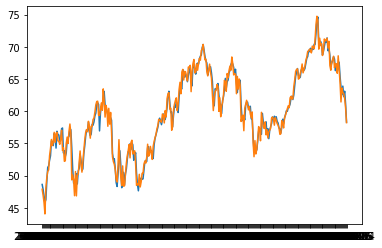

In [254]:
plt.plot(yhat_result)
plt.plot(expectdata)


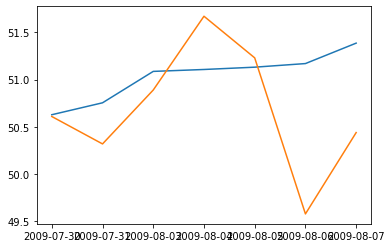

In [76]:
i=7
plt.plot((yhat_test[i].sum() * (y_test[i].max(axis=0) - y_test[i].min(axis=0))) + y_test[i].min(axis=0))
plt.plot(y_test[i])

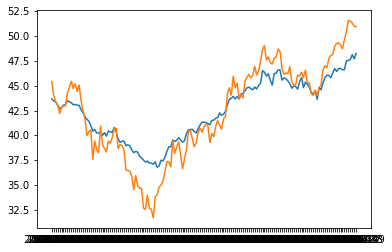

In [87]:
i=7
plt.plot((yhat_train[i].sum() * (y_train[i].max(axis=0) - y_train[i].min(axis=0))) + y_train[i].min(axis=0))
plt.plot(y_train[i])

In [290]:
dataset

,copper,nikkel,aluminium,ayeon,canada sp,sp500,ftse,shanghai,nikkei225,hangseng,...,EUR,CNY,JPY,GBP,canada60 future,SP500,EM,EAFE,Gold,WTI
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-19,8273.0,27975.0,2835.8,2345.00,13447.74,1348.78,5966.90,4664.30,13757.91,24123.17,...,1384.62,131.91,873.33,1843.05,788.8,135.31,46.7200,71.29,926.6,100.01
2008-02-20,8221.0,27878.0,2845.8,2345.00,13551.69,1360.03,5893.60,4567.03,13310.37,23590.58,...,1390.53,132.07,875.41,1839.54,797.4,136.36,47.1100,70.92,934.6,100.74
2008-02-21,8487.0,29035.0,2909.3,2524.50,13509.55,1342.53,5932.20,4527.18,13688.28,23623.00,...,1390.73,132.22,874.51,1835.17,794.3,134.79,46.4500,70.79,946.1,98.23
2008-02-22,8374.5,28190.0,2883.8,2486.50,13585.93,1353.11,5888.50,4370.28,13500.46,23305.04,...,1402.79,132.61,882.20,1859.34,798.1,135.92,47.0733,71.69,944.7,98.81
2008-02-25,8238.0,28035.0,2864.5,2482.75,13697.45,1371.80,5999.50,4192.53,13914.57,23269.14,...,1408.03,132.87,884.64,1869.10,804.2,137.59,47.9500,72.83,937.6,99.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,5967.5,10796.0,1907.8,2489.00,13935.44,2416.62,6721.17,2516.25,20166.19,25753.42,...,1293.10,163.44,1015.02,1430.15,834.9,242.35,38.5200,57.56,1288.6,45.59
2018-12-24,5931.8,10801.0,1897.8,2478.00,13780.19,2351.10,6685.99,2527.01,20166.19,25651.38,...,1277.87,163.00,1011.84,1420.72,823.7,236.09,38.1600,56.89,1302.4,42.53
2018-12-26,5931.8,10801.0,1897.8,2478.00,13780.19,2467.70,6685.99,2498.29,19327.06,25651.38,...,1284.25,162.82,1021.42,1427.48,823.7,247.67,38.9200,58.21,1303.7,46.22


In [295]:
EMscore = pd.read_csv('EMresult.csv')
EAFEscore = pd.read_csv('EAFEresult.csv')
SP500score = pd.read_csv('SP500result.csv')

scoredata = pd.merge(EMscore, EAFEscore, how = 'inner', left_on = 'Date', right_on = 'Date')
scoredata = pd.merge(scoredata, SP500score, how = 'inner', left_on = 'Date', right_on = 'Date')

scoredata = scoredata.set_index('Date')

returntable = ((dataset[7:].reset_index(drop=True)-dataset[:-7].reset_index(drop=True))/dataset[:-7].reset_index(drop=True))[['EM', 'EAFE', 'SP500']]
returntable.index = dataset[:-7].index

returncut = returntable[returntable.index.isin(scoredata.index)][['EM', 'EAFE', 'SP500']]

In [396]:
veryresult = []
idealresult = []
predictstring = []
expectstring = []
for i in range(0, len(scoredata)):
    if(scoredata['EM'][i] == (scoredata.max(axis = 1)[i])):
        veryresult.append(returncut['EM'][i]-0.0014)
        predictstring.append('EM')
    elif(scoredata['EAFE'][i] == (scoredata.max(axis = 1)[i])):
        veryresult.append(returncut['EAFE'][i]-0.0007)
        predictstring.append('EAFE')
    else:
        veryresult.append(returncut['SP500'][i]-0.0004)
        predictstring.append('SP500')
        
for i in range(0, len(scoredata)):
    if(returncut['EM'][i] == (returncut.max(axis = 1)[i])):
        expectstring.append('EM')
        idealresult.append(returncut['EM'][i]-0.0014)
    elif(returncut['EAFE'][i] == (returncut.max(axis = 1)[i])):
        expectstring.append('EAFE')
        idealresult.append(returncut['EAFE'][i]-0.0007)
    else:
        expectstring.append('SP500')
        idealresult.append(returncut['SP500'][i]-0.0004)


In [384]:
veryresult = pd.DataFrame(veryresult)

In [385]:
veryresult.index = scoredata.index

In [386]:
veryresult.to_csv('veryresult.csv')

In [392]:
accuracy = []
for i in range(0, len(predictstring)):
    if(predictstring[i] == expectstring[i]):
        accuracy.append(1)
    else:
        accuracy.append(0)

In [395]:
sum(accuracy)/len(predictstring)

0.5015197568389058

In [399]:
pd.DataFrame(idealresult).to_csv('idealresult.csv')